In [1]:
import numpy as np
import skimage as sk
import skimage.io as skio
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform
import os
import pdb

In [2]:
def ncc(im1, im2):
    im1_mean = np.linalg.norm(im1)
    im2_mean = np.linalg.norm(im2)
    
    numerator = np.sum((im1 - im1_mean) * (im2 - im2_mean))
    denominator = np.sqrt(np.sum((im1 - im1_mean) ** 2) * np.sum((im2 - im2_mean) ** 2))
    
    return numerator / denominator if denominator != 0 else 0

In [3]:
def calculate_displacement_euclidean(im1, im2, displacement_range=30):
    """
    Calculate the displacement that best aligns im2 to im1 using an exhaustive search over a given range.
    """
    best_offset = (0, 0)
    best_score = float('inf')  # Use infinity as the initial score
    
    for x in range(-displacement_range, displacement_range + 1):
        for y in range(-displacement_range, displacement_range + 1):
            # Shift the second image
            shifted_im2 = np.roll(np.roll(im2, y, axis=0), x, axis=1)
            
            # Calculate the L2 norm (Euclidean Distance)
            score = np.sum((im1 - shifted_im2) ** 2)
            
            # Update if a better score (lower score) is found
            if score < best_score:
                best_score = score
                best_offset = (y, x)
    
    return best_offset

In [4]:
def calculate_displacement_ncc(im1, im2, displacement_range=60):
    """
    Calculate the displacement that best aligns im2 to im1 using Normalized Cross-Correlation (NCC).
    """
    best_offset = (0, 0)
    best_score = -1  # NCC ranges from -1 to 1, so we start with the lowest possible value

    for x in range(-displacement_range, displacement_range + 1):
        for y in range(-displacement_range, displacement_range + 1):
            # Shift the second image
            shifted_im2 = np.roll(np.roll(im2, y, axis=0), x, axis=1)

            ncc_score = ncc(im1, shifted_im2)
            
            if ncc_score > best_score:
                best_score = ncc_score
                best_offset = (x, y)

    return best_offset

In [5]:
def calculate_displacement_pyramid(base_img, target_img, max_layers=5, scale_factor=0.25, search_range=100):
    base_pyramid = [base_img]
    target_pyramid = [target_img]

    for _ in range(1, max_layers):
        base_img = transform.rescale(base_img, scale_factor)
        target_img = transform.rescale(target_img, scale_factor)
        base_pyramid.append(base_img)
        target_pyramid.append(target_img)

    # Initialize best alignment at the coarsest scale
    best_shift = (0, 0)

    # Start from the coarsest level and refine the estimate
    for i in range(max_layers - 1, -1, -1):
        base_layer = base_pyramid[i]
        target_layer = target_pyramid[i]

        # Search for the best shift at the current level
        best_shift = calculate_displacement_euclidean(base_layer, target_layer, int(search_range * (0.7 ** (max_layers - 1 - i))))

        # Double the shift for the next finer level (since images are upscaled by factor of 2)
        best_shift = (best_shift[0] * 2, best_shift[1] * 2)

    return best_shift

In [6]:
def align(imname, align_type="pyramid", max_layers=5):
    im = skio.imread(imname) 
    im = sk.img_as_float(im)
    height = np.floor(im.shape[0] / 3.0).astype(int)

    b = im[:height]
    g = im[height: 2*height]
    r = im[2*height: 3*height]

    # Calculate the crop amount (15% of each dimension)
    crop_height = int(b.shape[0] * 0.15)
    crop_width = int(b.shape[1] * 0.15)

    # Crop the images
    b = b[crop_height:-crop_height, crop_width:-crop_width]
    g = g[crop_height:-crop_height, crop_width:-crop_width]
    r = r[crop_height:-crop_height, crop_width:-crop_width]

    from skimage import feature
    be = feature.canny(b)
    ge = feature.canny(g)
    re = feature.canny(r)
    # skio.imshow(be)
    # skio.show()
    


    if align_type == "pyramid":    
        g_offset = calculate_displacement_pyramid(b, g, max_layers=max_layers)
        r_offset = calculate_displacement_pyramid(b, r, max_layers=max_layers)
    elif align_type == "euclidean":
        g_offset = calculate_displacement_euclidean(b, g)
        r_offset = calculate_displacement_euclidean(b, r)
    elif align_type == "ncc":
        g_offset = calculate_displacement_ncc(b, g)
        r_offset = calculate_displacement_ncc(b, r)

    print("r: ", r_offset)
    print("g: ", g_offset)
    ag = np.roll(np.roll(g, g_offset[0], axis=0), g_offset[1], axis=1)
    ar = np.roll(np.roll(g, r_offset[0], axis=0), g_offset[1], axis=1)
    im_out = np.dstack([ar, ag, b])
    fname = f'../output/{os.path.basename(imname)}'
    skio.imsave(fname, sk.img_as_ubyte(im_out))
    print(fname, "saved!")

    # display the image
    skio.imshow(im_out)
    skio.show()
    return


In [7]:
def process_image(imname):
    # imname = os.path.join(data_folder, filename)
    if imname.lower().endswith('.tif'):
        print(f"Aligning image: {imname}")
        align(imname, "pyramid", max_layers=7)
    elif imname.lower().endswith('.jpg'):
        print(f"Aligning image: {imname}")
        align(imname, "pyramid", max_layers=4)

Aligning image: ../data/church.tifAligning image: ../data/emir.tifAligning image: ../data/monastery.jpgAligning image: ../data/three_generations.tifAligning image: ../data/melons.tif




r:  (6, 4)
g:  (-6, 4)
../output/monastery.jpg saved!


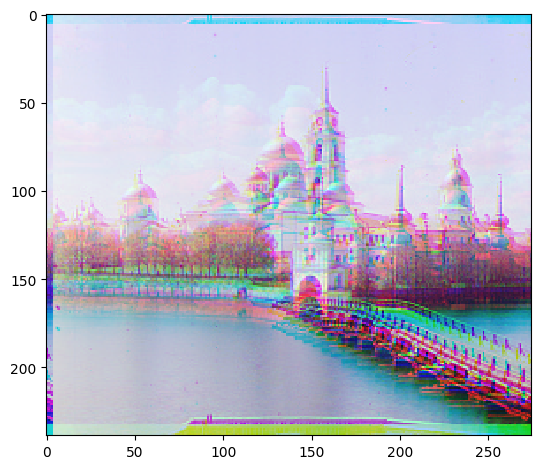

Aligning image: ../data/onion_church.tif
r:  (22, -22)
g:  (22, 8)
../output/church.tif saved!
r:  (22, 20)
g:  (22, 22)


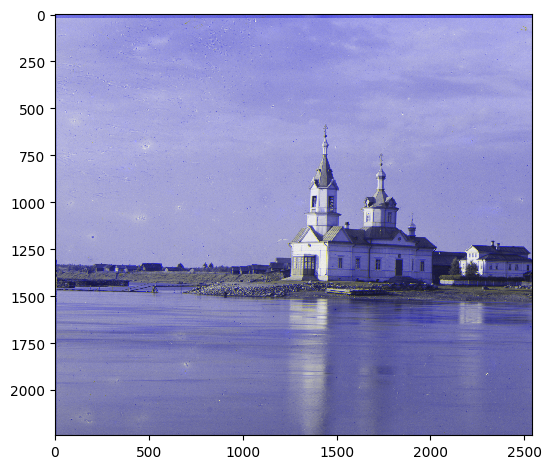

Aligning image: ../data/train.tif
r:  (22, -8)
g:  (22, 22)
../output/three_generations.tif saved!
r:  (22, 0)
../output/emir.tifg:  saved! 
(22, 0)
../output/melons.tif saved!


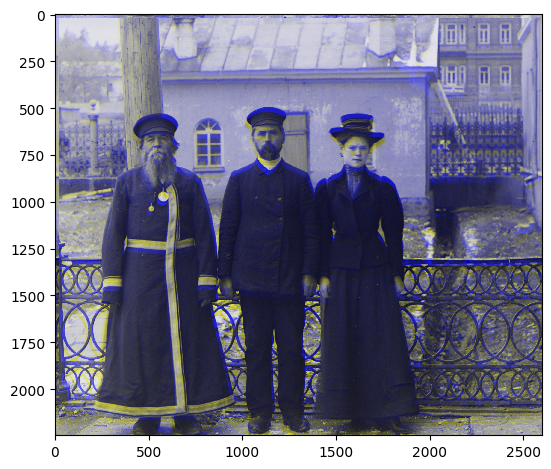

Aligning image: ../data/tobolsk.jpg


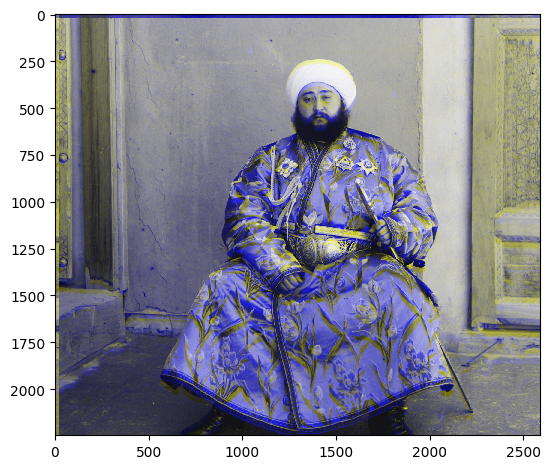

Aligning image: ../data/icon.tif


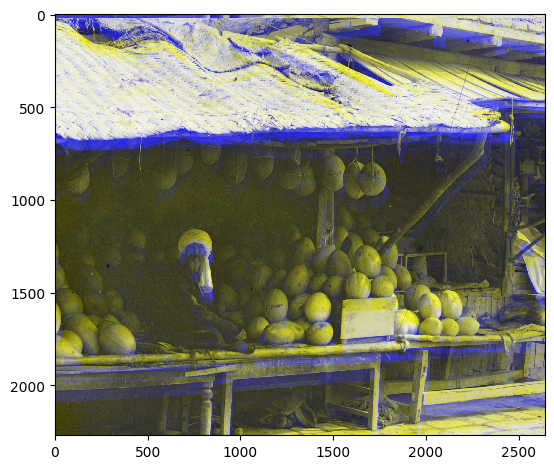

Aligning image: ../data/cathedral.jpg
r:  (22, 22)
g:  (22, 22)
../output/onion_church.tif saved!


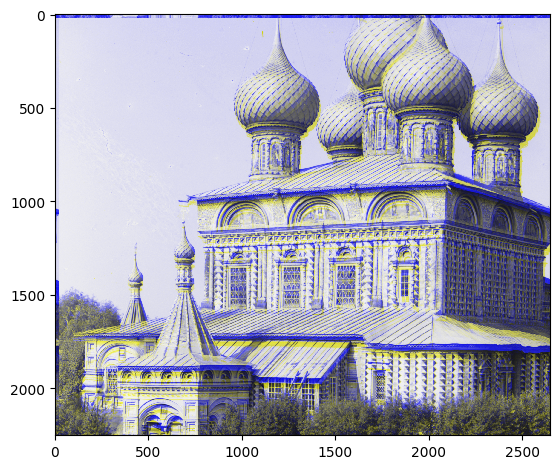

Aligning image: ../data/self_portrait.tif
r:  (12, 6)
g:  (6, 6)
../output/tobolsk.jpg saved!


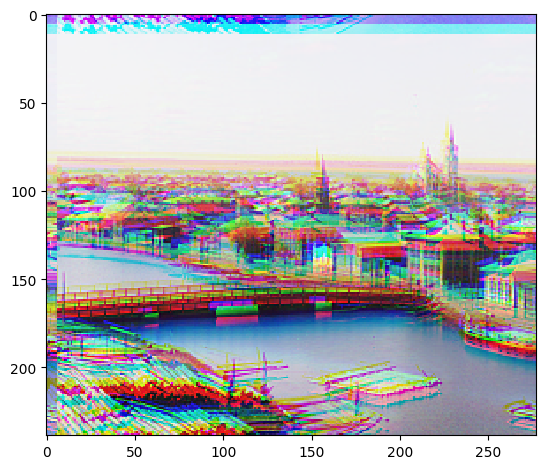

Aligning image: ../data/harvesters.tif
r:  (24, 6)
g:  (10, 4)
../output/cathedral.jpg saved!


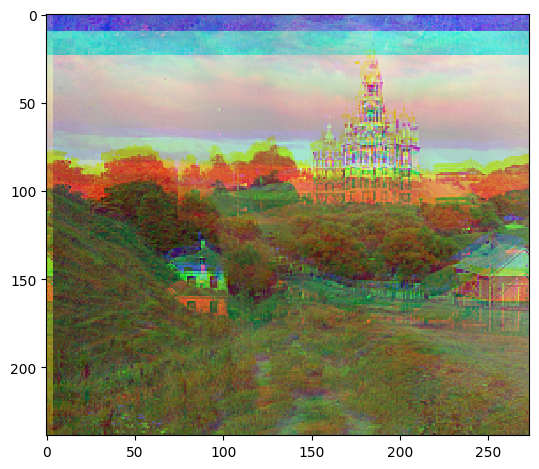

Aligning image: ../data/sculpture.tif
r:  (22, 0)
g:  (22, 18)
../output/train.tif saved!


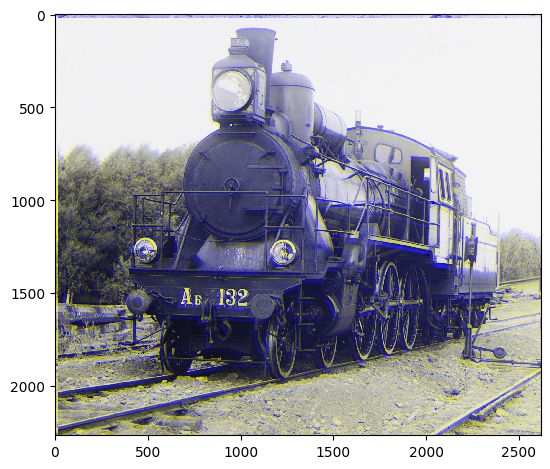

Aligning image: ../data/lady.tif
r:  (0, 22)
g:  (22, 22)
../output/icon.tif saved!


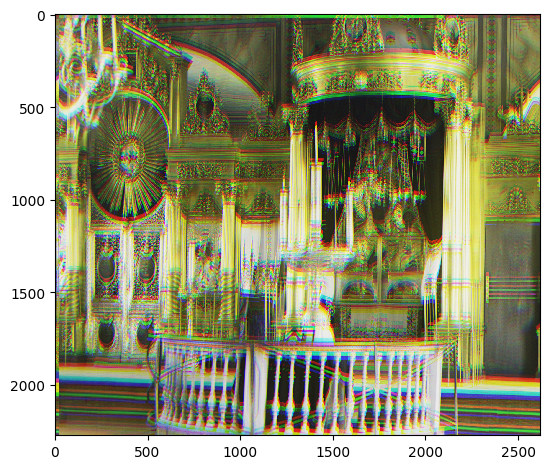

r:  (22, 22)
g:  (22, 22)
r:  (22, 22)
g:  (22, 22)
../output/harvesters.tif saved!../output/self_portrait.tif 
saved!


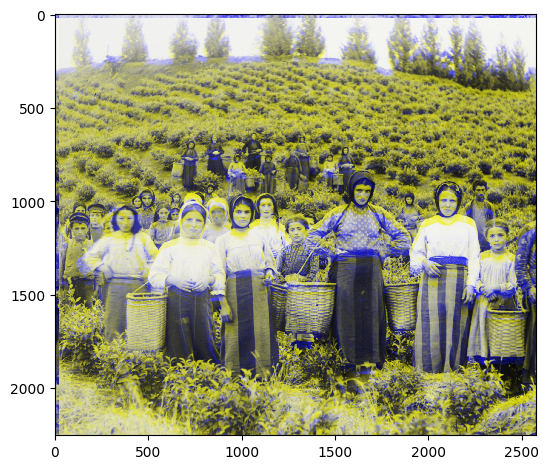

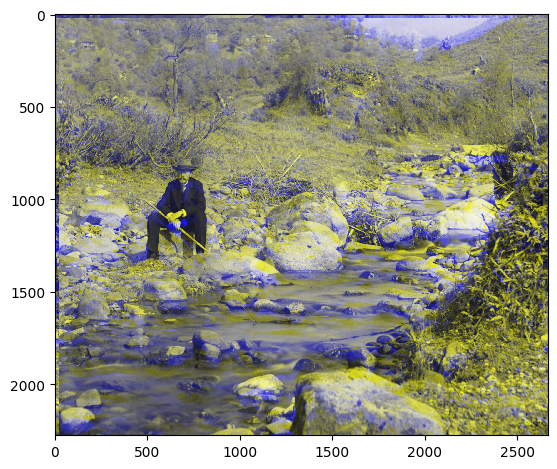

r:  (22, -22)
g:  (22, -22)
../output/sculpture.tif saved!


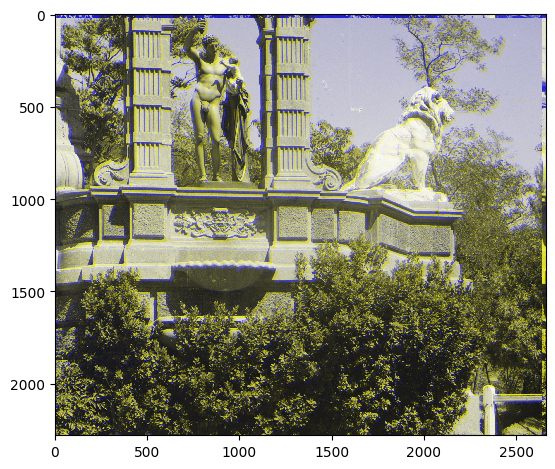

r:  (22, -22)
g:  (22, 14)
../output/lady.tif saved!


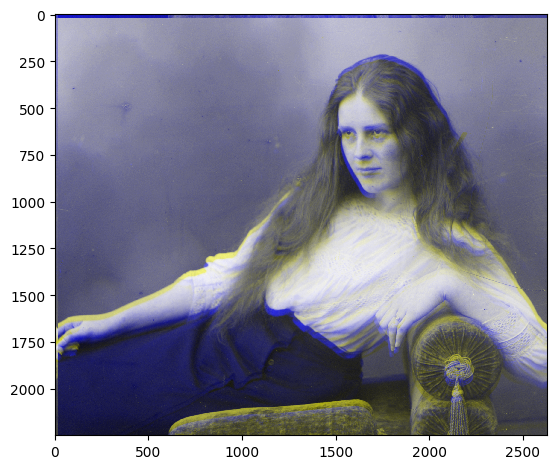

In [8]:
import multiprocess
data_folder = '../data'

# process_image('../data/church.tif')

# num_cores = multiprocessing.cpu_count()
pool = multiprocess.Pool(processes=5)

pool.map(process_image, [os.path.join(data_folder, f)  for f in os.listdir(data_folder)])
pool.close()
pool.join()

